# Associative Memory with **_Hopfield Recurrent Neural Network_**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from scipy.optimize import minimize


In [2]:
class HopfieldNetwork:
    def __init__(self, neurons_n=10, memories=None):
        """
        :param neurons_n: number of neurons, must be equal to dimensionality of memories.
        :param memories: an NxP array containing N memories; if not None, neurons_n is set to P.
        """
        if memories is not None:
            neurons_n = memories.shape[1]

        self._weights = np.zeros((neurons_n, neurons_n))
        self._memories_n = 0

        if memories is not None:
            self.add_memories(memories)

    def get_closest_memory(self, state: np.array, max_iter=10):
        prev = state.copy()
        nxt = state.copy()
        for _ in range(max_iter):
            nxt = self._get_next_step(nxt)
            if (nxt == prev).all():  # converged  (i.e., hasn't changed since last iteration)
                break
            prev = nxt
        return nxt

    def get_closest_memories(self, states, **kwargs):
        restored_memories = [] * len(states)
        for state in states:
            restored_memories.append(self.get_closest_memory(state, **kwargs))
        return restored_memories

    def add_memories(self, memories):
        memories = self.preprocess_memories(np.array(memories))
        old_weights_sum = self._weights * self._memories_n
        new_weights_sum = (memories.reshape(memories.shape[0], memories.shape[2], 1)  # multiply each of`shape[0]`
                           @ memories.reshape(memories.shape[0], 1, memories.shape[2])  # by its transpose
                           ).sum(axis=0)
        self._memories_n += len(memories)
        self._weights = (old_weights_sum + new_weights_sum) / self._memories_n

    def add_memory(self, memory):
        self.add_memories([memory])

    def _get_next_step(self, to):
        return np.sign((to @ self._weights) / len(self._weights))

    @staticmethod
    def preprocess_memories(memories: np.array):
        """
        Converts all positive elements to 1s, and the rest to -1s
        """
        return (-1 * (memories <= 0) + 1 * (memories > 0)).reshape(len(memories), -1)[:, np.newaxis, :]


Now we can try to make the network learn three digits from the MNIST dataset and then ask it to recall them from a sketch:

In [3]:
digits = load_digits()

In [4]:
use_digits = [0, 3, 6]
hop_net = HopfieldNetwork(memories=digits.data[use_digits])  # take first instances of each of chosen digits

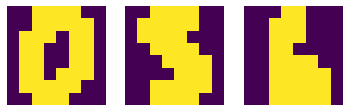

In [5]:
preprocessed_memories = HopfieldNetwork.preprocess_memories(digits.data[use_digits])
fig, axes = plt.subplots(1, len(use_digits))
for i, ax in enumerate(axes):
    ax.imshow(preprocessed_memories[i].reshape(8, 8))
    ax.axis('off')

(-0.5, 7.5, 7.5, -0.5)

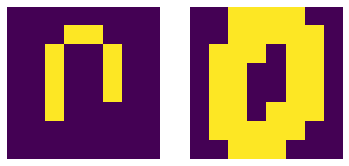

In [6]:
fig, axes = plt.subplots(1, 2)
guess = np.array([  # trying to mimic a zero
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
]).flatten()

axes[0].imshow(guess.reshape(8, 8))
axes[0].axis('off')

matched_memory = hop_net.get_closest_memory(guess)
axes[1].imshow(matched_memory.reshape(8, 8))
axes[1].axis('off')


(-0.5, 7.5, 7.5, -0.5)

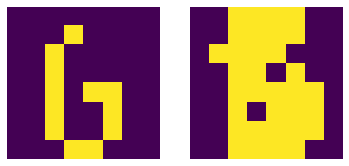

In [7]:
fig, axes = plt.subplots(1, 2)
guess = np.array([  # trying to mimic a six
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 1, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 1, 1, 0, 0, 0],
]).flatten()

axes[0].imshow(guess.reshape(8, 8))
axes[0].axis('off')

matched_memory = hop_net.get_closest_memory(guess)
axes[1].imshow(matched_memory.reshape(8, 8))
axes[1].axis('off')


In [8]:
def verify_capacity(neurons_n, memories_n):
    """
    Returns whether a Hopfild network with `neurons_n` neurons should be able to store `memories_n` memories.
    """
    random_memories = np.random.choice([-1, 1], (memories_n, neurons_n))
    corrupted_random_memories = random_memories.copy()
    corrupted_random_memories[:, np.random.randint(0, neurons_n)] *= -1  # jitter one bit

    return (np.array(HopfieldNetwork(memories=random_memories).get_closest_memories(corrupted_random_memories))
            == random_memories).all()


In [9]:
def get_max_capacity(neurons_n):
    """
    Returns the maximum number of memories a Hopfield network with `neurons_n` neurons can store.
    """
    return round(minimize(lambda x: -x[0] * verify_capacity(neurons_n, round(x[0])),
                          x0=[1], method='TNC', bounds=[(1, neurons_n)]).x[0])


In [10]:
neurons_ns = np.unique(np.geomspace(1, 1000, 20, dtype=int))
max_capacities = [get_max_capacity(n) for n in neurons_ns]

c:\users\breedoon\appdata\local\programs\python\python38\lib\site-packages\scipy\optimize\_numdiff.py:579: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


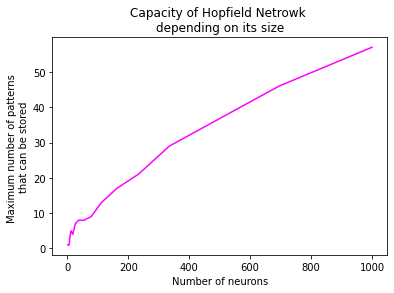

In [11]:
plt.plot(neurons_ns, max_capacities, color='magenta')
plt.title('Capacity of Hopfield Netrowk \ndepending on its size')
plt.ylabel('Maximum number of patterns \nthat can be stored')
plt.xlabel('Number of neurons')
plt.show()

The scaling behavior seems to be somewhat linear with a slope of about 0.05 memories per neuron.

In [ ]:
# Associative Memory with **_Hopfield Recurrent Neural Network_**

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from scipy.optimize import minimize


class HopfieldNetwork:
    def __init__(self, neurons_n=10, memories=None):
        """
        :param neurons_n: number of neurons, must be equal to dimensionality of memories.
        :param memories: an NxP array containing N memories; if not None, neurons_n is set to P.
        """
        if memories is not None:
            neurons_n = memories.shape[1]

        self._weights = np.zeros((neurons_n, neurons_n))
        self._memories_n = 0

        if memories is not None:
            self.add_memories(memories)

    def get_closest_memory(self, state: np.array, max_iter=10):
        prev = state.copy()
        nxt = state.copy()
        for _ in range(max_iter):
            nxt = self._get_next_step(nxt)
            if (nxt == prev).all():  # converged  (i.e., hasn't changed since last iteration)
                break
            prev = nxt
        return nxt

    def get_closest_memories(self, states, **kwargs):
        restored_memories = [] * len(states)
        for state in states:
            restored_memories.append(self.get_closest_memory(state, **kwargs))
        return restored_memories

    def add_memories(self, memories):
        memories = self.preprocess_memories(np.array(memories))
        old_weights_sum = self._weights * self._memories_n
        new_weights_sum = (memories.reshape(memories.shape[0], memories.shape[2], 1)  # multiply each of`shape[0]`
                           @ memories.reshape(memories.shape[0], 1, memories.shape[2])  # by its transpose
                           ).sum(axis=0)
        self._memories_n += len(memories)
        self._weights = (old_weights_sum + new_weights_sum) / self._memories_n

    def add_memory(self, memory):
        self.add_memories([memory])

    def _get_next_step(self, to):
        return np.sign((to @ self._weights) / len(self._weights))

    @staticmethod
    def preprocess_memories(memories: np.array):
        """
        Converts all positive elements to 1s, and the rest to -1s
        """
        return (-1 * (memories <= 0) + 1 * (memories > 0)).reshape(len(memories), -1)[:, np.newaxis, :]


digits = load_digits()

use_digits = [0, 3, 6]
hop_net = HopfieldNetwork(memories=digits.data[use_digits])  # take first instances of each of chosen digits

preprocessed_memories = HopfieldNetwork.preprocess_memories(digits.data[use_digits])
fig, axes = plt.subplots(1, len(use_digits))
for i, ax in enumerate(axes):
    ax.imshow(preprocessed_memories[i].reshape(8, 8))
    ax.axis('off')

fig, axes = plt.subplots(1, 2)
guess = np.array([  # trying to mimic a zero
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
]).flatten()

axes[0].imshow(guess.reshape(8, 8))
axes[0].axis('off')

matched_memory = hop_net.get_closest_memory(guess)
axes[1].imshow(matched_memory.reshape(8, 8))
axes[1].axis('off')


fig, axes = plt.subplots(1, 2)
guess = np.array([  # trying to mimic a zero
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 1, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 1, 1, 0, 0, 0],
]).flatten()

axes[0].imshow(guess.reshape(8, 8))
axes[0].axis('off')

matched_memory = hop_net.get_closest_memory(guess)
axes[1].imshow(matched_memory.reshape(8, 8))
axes[1].axis('off')


def verify_capacity(neurons_n, memories_n):
    """
    Returns whether a Hopfild network with `neurons_n` neurons should be able to store `memories_n` memories.
    """
    random_memories = np.random.choice([-1, 1], (memories_n, neurons_n))
    corrupted_random_memories = random_memories.copy()
    corrupted_random_memories[:, np.random.randint(0, neurons_n)] *= -1  # jitter one bit

    return (np.array(HopfieldNetwork(memories=random_memories).get_closest_memories(corrupted_random_memories))
            == random_memories).all()


def get_max_capacity(neurons_n):
    """
    Returns the maximum number of memories a Hopfield network with `neurons_n` neurons can store.
    """
    return round(minimize(lambda x: -x[0] * verify_capacity(neurons_n, round(x[0])),
                          x0=[1], method='TNC', bounds=[(1, neurons_n)]).x[0])


neurons_ns = np.unique(np.geomspace(1, 1000, 20, dtype=int))
max_capacities = [get_max_capacity(n) for n in neurons_ns]

plt.plot(neurons_ns, max_capacities, color='magenta')
plt.title('Capacity of Hopfield Netrowk \ndepending on its size')
plt.ylabel('Maximum number of patterns \nthat can be stored')
plt.xlabel('Number of neurons')
plt.show()

The scaling behavior seems to be somewhat linear with a slope of about 0.05 memories per neuron.